# Compute the sphercial wave functions' expansion of incident wave

In [1]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import math
import matplotlib.pyplot as plt

In [2]:
h = 0.3 # Size of the mesh
d = [1,0,0] # wave's travel direction
k = 5 # wavenumber

In [3]:
dom_cube = bempp.api.shapes.cube(length = 2/1.8, origin=(-1/1.8,-1/1.8,-1/1.8), h = h)
vert_cube = dom_cube.vertices
space_cube = bempp.api.function_space(dom_cube,'P',1)

In [4]:
def normalized_spherical_harmonics(p, q, x):
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    legd_poly = np.array(scipy.special.lpmn(abs(p),q, np.cos(polar))[0]) [-1,-1] 
    return np.sqrt(((2*q+1)/(4*np.pi))*(math.factorial(q-abs(p))/math.factorial(q+abs(p))))*legd_poly*np.exp(1j*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [5]:
def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)
    return coeff

In [6]:
@bempp.api.complex_callable
def inc_wave_fun(x,n,domain_index, result):
    result[0] = np.exp(1j*k*x[0])
    
inc_wave_grid_fun_cube = bempp.api.GridFunction(space_cube, fun = inc_wave_fun)

In [7]:
error_cube = []
for deg in range(20):
    @bempp.api.complex_callable
    def wave_expansion_cube(x,n,domain_index,result):
        with objmode():
            basis_fun = []    
            coeff = []
            for q in range(deg+1):
                for p in range(-q,q+1):
                    basis_fun.append(regular_spherical_wavefunctions(p,q,x))
                    coeff.append(coeff_sph_expansion(p,q))
            result[0] = np.inner(coeff,basis_fun)

    wave_grid_fun_cube = bempp.api.GridFunction(space_cube, fun = wave_expansion_cube)
    error_cube.append((inc_wave_grid_fun_cube - wave_grid_fun_cube).l2_norm())

Text(0, 0.5, 'l2-norm error')

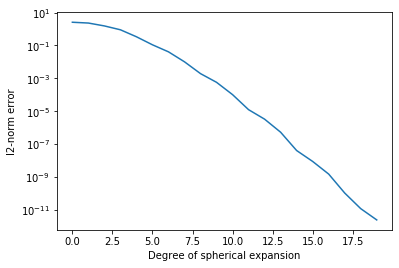

In [8]:
plt.semilogy(range(20),error_cube)
plt.xlabel('Degree of spherical expansion')
plt.ylabel('l2-norm error')